## Net Promoter Score - Product Investigation:

This example demonstrates how a product owner can evaluate customer satisfaction from online reviews at scale. This process provides managers with higher fidelity information about the online market's sentiment for a product with specific justifications, allowing for more timely, accurate business decisions. 

Process: a product was selected at random from those containing over 75 reviews. Reviews were then segmented for investigation by sentiment analysis score. Exploring the review score's top and bottom tiers, clear insights emerge for actionable improvements. 

In [1]:
import pandas as pd
import numpy as np
import re
import string
import pickle
import nltk
import spacy
from pymongo import MongoClient
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim import corpora, models, similarities, matutils
from gensim.corpora import Dictionary
import gensim

from corextopic import corextopic as ct
from corextopic import vis_topic as vt
import scipy.sparse as ss

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### Data Import:

This data for this project were stored in MongoDB on AWS EC2 and accessed using the PyMongo module. The following code establishes connection, extracts a user-defined number of records from the electronics reviews collection, scans for null values, and creates a new dataframe for the columns of interest.

Star reviews are scaled to Net Promoter Scores with the following assumptions: 5 stars equates to a promoter, 4 stars is neutral, and 1-3 stars is a detractor.

In [ ]:
# connect to Mongo on AWS and pull data:

client = MongoClient('mongodb://username@1234567890:27017/amazon_reviews', password = '1234567890')

db = client.amazon_reviews
    
try:
    if db.list_collection_names() == ['electronics']:
        print("Connected to MongoDB on AWS EC2.\n")
    
    total_records = int(input('Specify number of records:'))
        
    # pull reviews from electronics category to load dataframe:
    elec = list(db.electronics.find().limit(total_records))
    df = pd.DataFrame(list(elec))
    print('>>', df.shape[0],'reviews retrieved from database\n')

except:
    print("Connection Error.")
    
check_null = df.isnull().values.any()
print('Null values in df =', check_null, '\n')

df = df[['product_id', 'product_title', 'review_body', 'review_headline', 'star_rating', 'total_votes', 'verified_purchase', 'vine']]

# Assign 5 star reviews to 1, 4 star reviews to 0, and 1-3 star reviews to -1:
df['nps'] = np.where(df['star_rating'] == 5, 1, np.where(df['star_rating'] == 4, 0, -1))

print('Unique products:', len(list(df.product_id.unique())),'\n')

df.to_pickle('./data/df_records.pkl') 

df.head()

In [2]:
df = pickle.load(open('./data/df_records.pkl', 'rb'))
df.head()

,product_id,product_title,review_body,review_headline,star_rating,total_votes,verified_purchase,vine,nps
0,B00428R89M,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,As described.,Five Stars,5,0,Y,N,1
1,B000068O48,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",It works as advertising.,It works as advertising.,5,0,Y,N,1
2,B000GGKOG8,Channel Master Titan 2 Antenna Preamplifier,Works pissa,Five Stars,5,1,Y,N,1
3,B000NU4OTA,LIMTECH Wall charger + USB Hotsync & Charging ...,Did not work at all.,One Star,1,0,Y,N,-1
4,B00JOQIO6S,Skullcandy Air Raid Portable Bluetooth Speaker,Works well. Bass is somewhat lacking but is pr...,Overall pleased with the item,5,1,Y,N,1


In [3]:
# create dataframe of products with > 75 reviews:
df_counts = df.groupby(['product_id']).count().sort_values('product_title', ascending = False)
sort_mask = (df_counts['product_title'] > 75)

df_counts[sort_mask].head()

,product_title,review_body,review_headline,star_rating,total_votes,verified_purchase,vine,nps
product_id,,,,,,,,
B003L1ZYYM,86,86,86,86,86,86,86,86


In [4]:
# for this example, the 3rd product was "randomly" selected:
product_mask = (df['product_id'] == 'B00F5NE2KG')
df_product = df[product_mask]
df_product.head()

,product_id,product_title,review_body,review_headline,star_rating,total_votes,verified_purchase,vine,nps
615,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Nice sound. It cuts out from time to time and ...,Nice sound. It cuts out from time to time ...,4,0,Y,N,0
922,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",The sound is pretty good; most important; it w...,A 100% compatible!!,5,0,Y,N,1
965,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Very impressed with the sound quality of this ...,It is a convenient size for travel and I love it!,5,0,Y,N,1
1019,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Sound is ok. Main issue it constant Dropping o...,"Connectivity Issues, Ok Sound.",1,0,Y,N,-1
1047,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Love this little guy. good sound and battery l...,In love!,4,0,Y,N,0


#### Exploratory Data Analysis:

As is often the case with online reviews, this product's ratings are skewed left with median equal to the max of 5 stars. As a derivative of star ratings, Net Promoter Score follows a similar pattern. With both medians also equal to the highest rating, we can hypothesize that there is signal loss in simplified ratings systems.

In [5]:
df_product.describe()

,star_rating,total_votes,nps
count,57.000000,57.000000,57.000000
mean,4.315789,0.052632,0.421053
std,1.037819,0.225282,0.777987
min,1.000000,0.000000,-1.000000
25%,4.000000,0.000000,0.000000
50%,5.000000,0.000000,1.000000
75%,5.000000,0.000000,1.000000
max,5.000000,1.000000,1.000000


Mean Star Rating: 4.315789473684211
Median Star Rating: 5.0


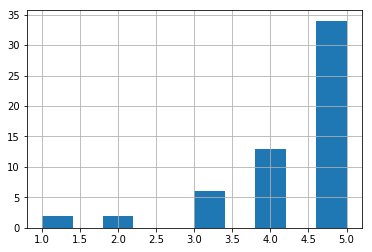

In [6]:
df_product.star_rating.hist()

print("Mean Star Rating:", df_product.star_rating.mean())
print("Median Star Rating:", df_product.star_rating.median())

Mean NPS Rating: 0.42105263157894735
Median NPS Rating: 1.0


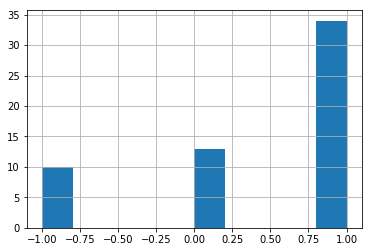

In [7]:
df_product.nps.hist()

print("Mean NPS Rating:", df_product.nps.mean())
print("Median NPS Rating:", df_product.nps.median())

#### Text Pre-processing:

The text data are processed with spaCy and loaded to a new column. The functions `alphanumeric` and `punc_lower` remove unwanted punctuation and convert text to lowercase, respectively.

In [8]:
nlp = spacy.load("/anaconda3/lib/python3.7/site-packages/en_core_web_sm/en_core_web_sm-2.1.0")

stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words.update(['-PRON-', 'pron', 'br', '<br/>', '<br />', '<br>', '<br', 'br>', '</br', 'br/>', '<br /><br />', 'use', 'like', '/br', 'br/'])

# Prepare data to process with Spacy:

list_of_spacy = []

for document in nlp.pipe(df_product.review_body, n_threads = -1):
    try:
        list_of_spacy.append(document)
        
    except:
        list_of_spacy.append('bad_doc')
        print('bad doc:', document)
    
df_product['review_body_spacy'] = list_of_spacy

print(f'{len(list_of_spacy)} documents processed with Spacy\n')
df_product.to_pickle('./data/df_product-spacy.pkl') 

# pre-process text with NLTK for Corex:

alphanumeric = lambda x: re.sub(r'<[^>]*>\w*\d\w*', '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

words = set(nltk.corpus.words.words())

nltk_list = []

df_product['cleaned_review_body_text'] = df_product['review_body_spacy'].apply\
(lambda x: ' '.join([ele.lemma_ for ele in x if ele.lemma_ not in stop_words and ele not in stop_words]))

for row in df_product['cleaned_review_body_text']:
    nltk_list.append(' '.join(w for w in nltk.wordpunct_tokenize(row) if w.lower() in words or not w.isalpha()))
    
df_product['nltk_terms'] = nltk_list
df_product['nltk_terms'] = df_product['nltk_terms'].map(alphanumeric).map(punc_lower)
df_product = df_product.drop(columns = ['cleaned_review_body_text'])

print('NLTK processing complete.')
df_product.to_pickle('./data/df_product-nltk.pkl') 
df_product.head()

57 documents processed with Spacy

NLTK processing complete.


,product_id,product_title,review_body,review_headline,star_rating,total_votes,verified_purchase,vine,nps,review_body_spacy,nltk_terms
615,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Nice sound. It cuts out from time to time and ...,Nice sound. It cuts out from time to time ...,4,0,Y,N,0,"(Nice, sound, ., It, cuts, out, from, time, to...",nice sound cut time time occasionally stop pl...
922,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",The sound is pretty good; most important; it w...,A 100% compatible!!,5,0,Y,N,1,"(The, sound, is, pretty, good, ;, most, import...",sound pretty good important work blackberry ...
965,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Very impressed with the sound quality of this ...,It is a convenient size for travel and I love it!,5,0,Y,N,1,"(Very, impressed, with, the, sound, quality, o...",sound quality device convenient size travel l...
1019,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Sound is ok. Main issue it constant Dropping o...,"Connectivity Issues, Ok Sound.",1,0,Y,N,-1,"(Sound, is, ok, ., Main, issue, it, constant, ...",sound main issue constant dropping connection...
1047,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Love this little guy. good sound and battery l...,In love!,4,0,Y,N,0,"(Love, this, little, guy, ., good, sound, and,...",love little guy good sound battery life rang...


#### NLP Hypothesis Test:

Before delving into a protracted NLP analysis to find fidelity in language where the ratings have disappointed, it is important to determine whether a general correlation between product reviews and ratings exists. 

This will be accomplished by applying classification to a Bag-of-Words model, specifically using CountVectorizer and Logistic Regression. 

In [9]:
# create a new dataframe with review body text and nps:

df2 = df[['review_body', 'nps']]
df2 = df2.drop(df2[df2.nps == 0].index) # remove neutral rating (4 stars) for binary classification
df2.head()

,review_body,nps
0,As described.,1
1,It works as advertising.,1
2,Works pissa,1
3,Did not work at all.,-1
4,Works well. Bass is somewhat lacking but is pr...,1


In [10]:
# define features & labels:

X = df2.review_body.values.astype('unicode')
y = df2.nps

# split into training / test sets:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# document-term matrix for default Count Vectorizer values - counts of unigrams:

cv1 = CountVectorizer(max_features=20000, stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", binary=True)

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

,aa,aaa,aaaa,aaas,aback,abc,abd,abdtech,abide,abigail,...,zippers,zipping,zippy,zips,zone,zones,zonk,zoom,zowie,zune
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# document-term matrix has both unigrams and bigrams, and indicators instead of counts:

cv2 = CountVectorizer(max_features=20000, stop_words='english', ngram_range=(1,2), token_pattern="\\b[a-z][a-z]+\\b", binary=True)
                    
X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

,aa,aa aaa,aa batteries,aa battery,aa rechargeable,aaa,aaa aa,aaa batteries,aaa battery,aaa just,...,zip,zip ties,zipbuds,ziploc,ziploc bag,zipper,zippered,zone,zones,zune
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Create a logistic regression model to use
lr = LogisticRegression()

# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

In [13]:
# Create a function to calculate the error metrics, since we'll be doing this several times

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

#### Results:

The supervised learning trial confirms a strong connection between reviews and ratings with all metrics above 90% and F1 scores nearing 94%.

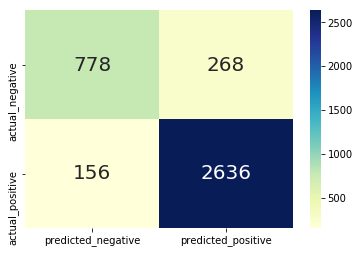

In [14]:
# Heat map for the first logistic regression model:

cm1 = conf_matrix(y_test, y_pred_cv1)

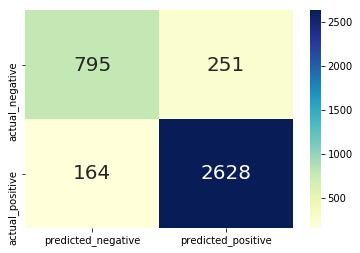

In [15]:
# Heat map for the second logistic regression model

cm2 = conf_matrix(y_test, y_pred_cv2)

In [16]:
# Compare results:

results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

,LogReg1,LogReg2
Accuracy,0.890,0.892
Precision,0.908,0.913
Recall,0.944,0.941
F1 Score,0.926,0.927


#### VADER Sentiment Analysis:

The star ratings & NPS data's extreme left skew exhibits a bias for 5 Star Ratings. How then does a product discern between those 5 Star Ratings from lethargic or generous customers and those reviews indicative of raving fans?

The most enthusiastic fans were isolated from the "5-Star by Default" population using Valence Aware Dictionary and sEntiment Reasoner (VADER) Sentiment Analysis. A filter coupling VADER scores over 0.95 with an NPS Score of 1 (as a checksum for sarcasm) was then used to populate a dataframe comprised of our most satisfied customers. This process was then repeated with inverse parameters to isolate the least satisfied customers.

In [17]:
# use VADER with original reviews column as input to include emotionally rich punctuation and capitalization: 

analyzer = SentimentIntensityAnalyzer()

# compound is the normalized, weighted composite score:

df_product['vader'] = [analyzer.polarity_scores(row)['compound'] for row in df_product.review_body] 

print(f'created VADER scores for {df_product.vader.shape[0]} rows\n')

df_product.head()

created VADER scores for 57 rows



,product_id,product_title,review_body,review_headline,star_rating,total_votes,verified_purchase,vine,nps,review_body_spacy,nltk_terms,vader
615,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Nice sound. It cuts out from time to time and ...,Nice sound. It cuts out from time to time ...,4,0,Y,N,0,"(Nice, sound, ., It, cuts, out, from, time, to...",nice sound cut time time occasionally stop pl...,0.3848
922,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",The sound is pretty good; most important; it w...,A 100% compatible!!,5,0,Y,N,1,"(The, sound, is, pretty, good, ;, most, import...",sound pretty good important work blackberry ...,0.8829
965,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Very impressed with the sound quality of this ...,It is a convenient size for travel and I love it!,5,0,Y,N,1,"(Very, impressed, with, the, sound, quality, o...",sound quality device convenient size travel l...,0.8353
1019,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Sound is ok. Main issue it constant Dropping o...,"Connectivity Issues, Ok Sound.",1,0,Y,N,-1,"(Sound, is, ok, ., Main, issue, it, constant, ...",sound main issue constant dropping connection...,0.2960
1047,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port...",Love this little guy. good sound and battery l...,In love!,4,0,Y,N,0,"(Love, this, little, guy, ., good, sound, and,...",love little guy good sound battery life rang...,0.9736


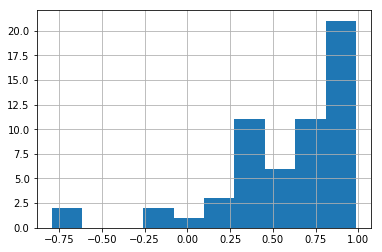

In [18]:
df_product.vader.hist()

In [19]:
df_product.corr()

,star_rating,total_votes,nps,vader
star_rating,1.000000,-0.148735,0.938209,0.311575
total_votes,-0.148735,1.000000,-0.128698,-0.358547
nps,0.938209,-0.128698,1.000000,0.316182
vader,0.311575,-0.358547,0.316182,1.000000


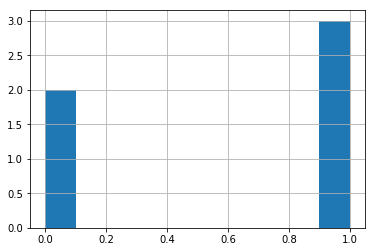

In [20]:
# explore top reviews using a vader filter > 0.95:

df_p1_top_mask = (df_product['vader'] > 0.95)

df_product[df_p1_top_mask].nps.hist()

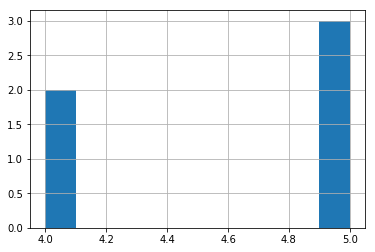

In [21]:
df_product[df_p1_top_mask].star_rating.hist()

In [22]:
# use a combination of vader and nps to create dataframe for top and bottom reviews:

df_p1_top_mask = (df_product['vader'] > 0.95) & (df_product['nps'] == 1)
df_top = df_product[df_p1_top_mask]

df_p1_bot_mask = (df_product['vader'] < -0.25) & (df_product['nps'] == -1)
df_bot = df_product[df_p1_bot_mask]


In [23]:
cor_vectorizer = CountVectorizer(max_features=20000, ngram_range=(1,2), binary=True, token_pattern="\\b[a-z][a-z]+\\b", stop_words='english')

cor_doc_word_top = cor_vectorizer.fit_transform(df_top['nltk_terms'])
cor_words = list(np.asarray(cor_vectorizer.get_feature_names())) 
topic_model_top = ct.Corex(n_hidden=6, words = cor_words, seed=1)
topic_model_top.fit(cor_doc_word_top, words = cor_words, docs = df_top.nltk_terms)

# repeat process for bottom reveiws:

cor_doc_word_bot = cor_vectorizer.fit_transform(df_bot['nltk_terms'])
cor_words = list(np.asarray(cor_vectorizer.get_feature_names()))
topic_model_bot = ct.Corex(n_hidden=6, words = cor_words, seed=1) # must be repeated
topic_model_bot.fit(cor_doc_word_bot, words = cor_words, docs = df_bot.nltk_terms)


#### Topic Evaluation: Top Reviews

CorEx topic models operate on the principle of mutual information between topic words and the topic - not the highest probability of a topic word occurring. 

In [24]:
# Print all topics from the top topic model:

topics = topic_model_top.get_topics()
for n, topic in enumerate(topics):
    if topic:
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))

0: able compatible,quiet,product include,product budget,pretty impressive,power able,power,portable easy,place bass,place
1: able volume,pretty good,pretty sure,price sound,quality pretty,shower,shower clearly,shower sound,shower year,singing
2: gift absolutely,hear away,irresistible,irresistible product,music outside,music travel,need,need size,outside,outside play
3: volume
4: sound


In [25]:
# retrieve original reviews & top topics for parameters specified:

def TopicReviews(topic_number, topic_model_version, topic_dataframe):
    
    print('Topics: \n\n', topic_model_version.get_topics()[topic_number])

    top_docs = topic_model_version.get_top_docs(topic=topic_number, n_docs=3)

    for i in top_docs:
        temp = (topic_dataframe.loc[topic_dataframe['nltk_terms'] == i[0]]).index[0]  # get row index of review for original review
        print('\nIndex:', temp)
        print('Rating:', df.star_rating.iloc[temp])
        print('Review:', df.review_body.iloc[temp])  # print original review

#### Topic 0: 

In Topic 0, we can see that the word "quality" has the highest mutual information and sets the general topic theme. From Topic 0's other top words, we can find other specific justifications for why customers wrote enthusiastically positive reviews: 

* convenient
* simple
* works in wet environments (sauna)

CorEx also allows us to `get_top_docs` to read the reviews most highly correlated with a topic. Since the text processing makes the CorEx input reviews difficult to read, I've indexed the original reviews for legibility.

The top 3 reviews give us a better idea of what is meant by the "quality" topic: sound. Customers also like the size and portability.
From a marketing perspective, these reviews that best define our quality topic tell us that customers are purchasing the product for their kids and as gifts.

In [26]:
TopicReviews(0, topic_model_top, df_top)

Topics: 

 [('able compatible', 0.7290328700921559), ('quiet', 0.7290328700921559), ('product include', 0.7290328700921559), ('product budget', 0.7290328700921559), ('pretty impressive', 0.7290328700921559), ('power able', 0.7290328700921559), ('power', 0.7290328700921559), ('portable easy', 0.7290328700921559), ('place bass', 0.7290328700921559), ('place', 0.7290328700921559)]

Index: 5066
Rating: 5
Review: By satisfying people around the world with convenient bluetooth speakers, we would like to introduce the DKnight MagicBox, a portable and easy to use speaker. The product includes enhanced bass, a built in microphone for phone calls, and 10W Output Power. Its bluetooth is able to be compatible with many types of bluetooth-enabled devices. It also contains a built-in 2000mA rechargable battery that may last you for a long time whenever you're at various destinations. The Magicbox can be carried around for personal use or at a party. Its wireless range is up to 33 ft, so you are capa

#### Topic 1:

Topic 1's general theme is **exceeds expectations**. Not only is "*expect*" the top topic words, but the top documents show a relationship between its "smaller than expected" size producing "more than we expected for sound quality." This is all given, "I did not expect much given its moderate price." For a product named "MagicBox," exceeding expectations is brand-consistent.

Topic 1 also reinforces insights from Topic 0: customers are buying the speaker for their children, giving it as gifts, and using it in wet environments.

In [27]:
TopicReviews(1, topic_model_top, df_top)

Topics: 

 [('able volume', 0.7290328700921559), ('pretty good', 0.7290328700921559), ('pretty sure', 0.7290328700921559), ('price sound', 0.7290328700921559), ('quality pretty', 0.7290328700921559), ('shower', 0.7290328700921559), ('shower clearly', 0.7290328700921559), ('shower sound', 0.7290328700921559), ('shower year', 0.7290328700921559), ('singing', 0.7290328700921559)]

Index: 11750
Rating: 5
Review: Darn thing works too good. Bought this as a gift for our 15-year-old.  I did not think it would perform or sound as good as it does.  I did not expect much given its moderate price.  But it really puts out the sound, much to my chagrin. Our son plays it in the bathroom while he is showering and we can clearly hear it over the shower and his 15-year-old singing and shower sounds.  When I am able to get over the volume, the sound quality is pretty good too, although I still don't understand any of his music.  Still trying to figure out what &#34;back it up&#34; means.  I am pretty su

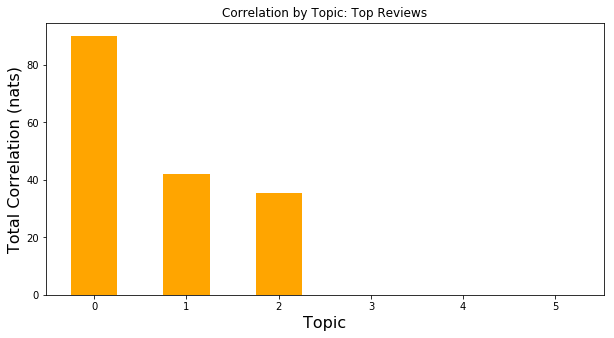

In [28]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model_top.tcs.shape[0]), topic_model_top.tcs, color='#ffa500', width=0.5)
plt.title('Correlation by Topic: Top Reviews')
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

#### Topic Evaluation: Bottom Reviews


In [29]:
# Print all topics from the bottom topic model:

topics = topic_model_bot.get_topics()
for n, topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: control new,new,new version,volume control
1: box,little box
2: control
3: box volume,version,volume
4: difficult,little
5: version difficult


#### Topic 0:

This topic words show clustering around sound issues when using Bluetooth:

* high frequency noise
* audio quality
* pairing & range

These findings are surprising considering that most reviews are positive and mention superb sound quality. Further, 2 of the top documents mention the sound quality improving when operating from an auxillary cable. 

This topic reveals a potential manufacturing or component problem involving Bluetooth that is detracting from product performance.

In [30]:
TopicReviews(0, topic_model_bot, df_bot)

Topics: 

 [('control new', -0.0), ('new', -0.0), ('new version', -0.0), ('volume control', -0.0)]

Index: 7806
Rating: 2
Review: It's a crappy little box. No volume controls (the new version has them), difficult to use.


#### Topic 1:

Topic 1 shares the defective product theme with Topic 0 and it follows that a top document is also repeated. However, this topic offers more information as to how the product is failing: 

* broken charge port
* defective volume controls

Since this product was sold online and reviews can be mapped to customers, the management has the ability to investigate supply chain and / or manufacturing patterns causing this defective lot.

In [31]:
TopicReviews(1, topic_model_bot, df_bot)

Topics: 

 [('box', 0.0), ('little box', 0.0)]

Index: 7806
Rating: 2
Review: It's a crappy little box. No volume controls (the new version has them), difficult to use.


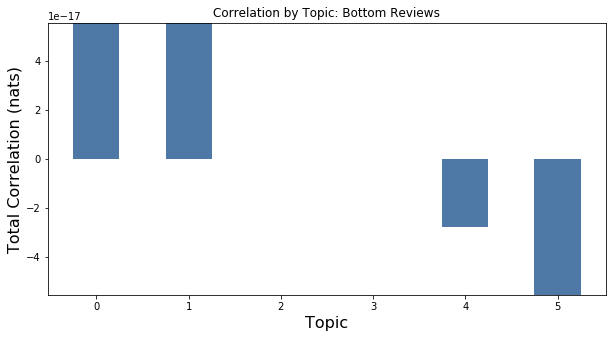

In [32]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model_bot.tcs.shape[0]), topic_model_bot.tcs, color='#4e79a7', width=0.5)
plt.title('Correlation by Topic: Bottom Reviews')
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);